<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
import torch.nn as nn
import torch.nn. functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [2]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle competitions download -c dog-breed-identification

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip dog-breed-identification.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  in

Let's use 64 most frequent breeds to simplify the task.

In [6]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = '/content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [7]:
labels.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [8]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(4838, 65) (1210, 65)


<ipython-input-8-0037ea12ab23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1
<ipython-input-8-0037ea12ab23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['rank'] = labels.groupby('breed').rank()['id']


Custom dataset is going to be useful for our needs.

In [9]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [10]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

print (len(train_ds))
print(len(valid_ds))

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

4838
1210


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


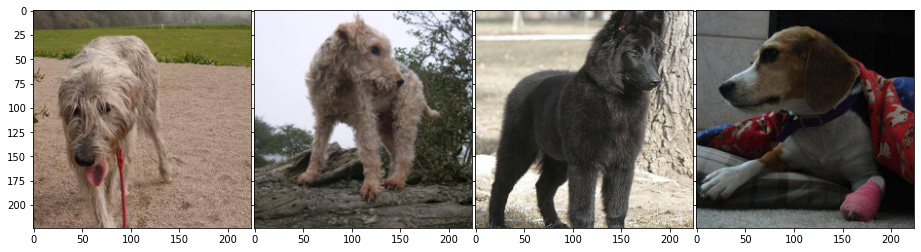

In [12]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 1000])

In [14]:
for x,y in train_dl:
  print(x.size())
  print (y.size())
  break

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [15]:
import copy

This models provides us with 1000 values, representing the classes which ResNet was trained on. 

Replace last layer with one that predicts the 64 classes. 
The network weights should be fixed expected for the last layer that is trained.

In [16]:
def train_model(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)


      model.train()  # Set model to training mode    
      running_loss = 0.0
      running_corrects = 0
      running_corrects_valid = 0
      t_counter = 0
      v_counter = 0

      for inputs, labels in dataloders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        t_counter += 1

      
            
      scheduler.step()

      model.eval()

      for inputs , labels in dataloders['valid']:

        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
        running_corrects_valid += torch.sum(preds == labels.data)
        v_counter += 1


      print (running_corrects)
      print (running_corrects_valid)
      epoch_loss = running_loss / 4838
      epoch_train_acc = running_corrects.double() / 4838
      epoch_valid_acc = running_corrects_valid.double()/ 1210 

      print(f' Training Loss: {epoch_loss:.4f} train_Acc: {epoch_train_acc:.4f} valid_Acc: {epoch_valid_acc:.4f}')

      if epoch_valid_acc > best_acc:
        best_acc = epoch_valid_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      print()

    # YOUR CODE
    model.load_state_dict(best_model_wts)


    return model

In [17]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features

resnet.fc = torch.nn.Linear(resnet.fc.in_features, 120)

resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in resnet.parameters() if param.requires_grad], lr=0.0003)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [18]:
model = train_model(dloaders, resnet, criterion, optimizer, scheduler)

Epoch 0/0
----------
tensor(1897, device='cuda:0')
tensor(951, device='cuda:0')
 Training Loss: 2.6554 train_Acc: 0.3921 valid_Acc: 0.7860



In [19]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

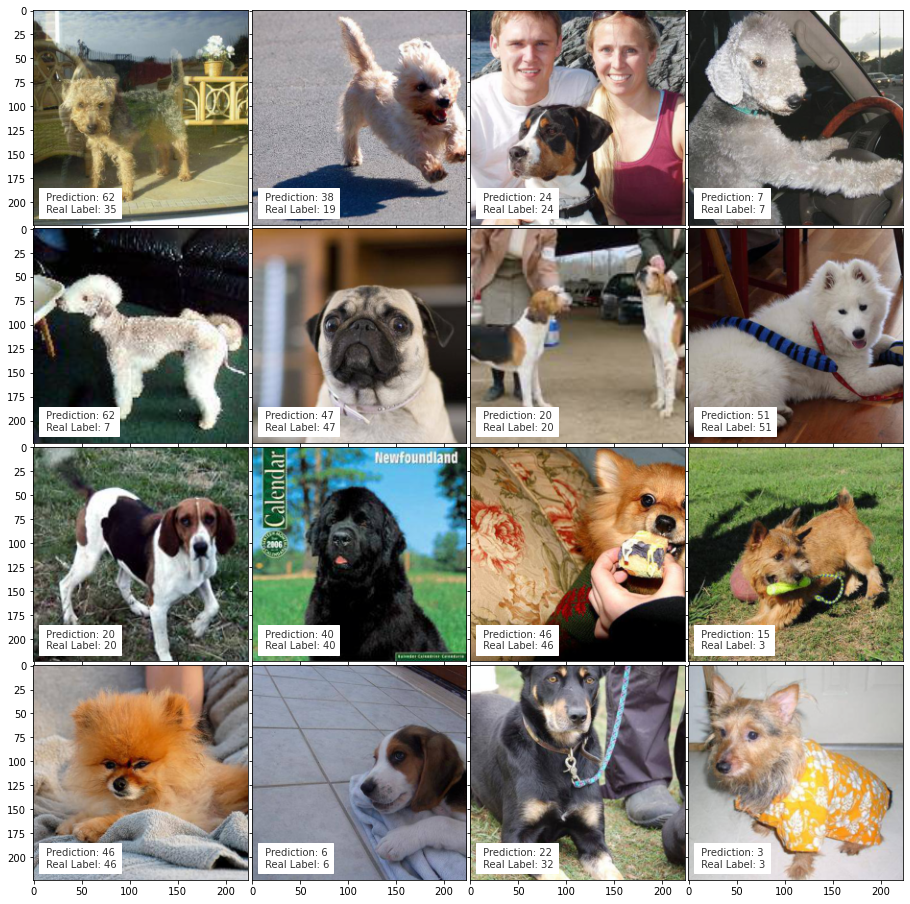

In [20]:
visualize_model(dloaders, model)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session). 

In [21]:
# cnnae = CNNAE().to(device)
# optimizer = torch.optim.Adam([param for param in cnnae.parameters() if param.requires_grad], lr=0.0003)
# criterion = nn.MSELoss(reduction="sum")

# for i,(x,y) in enumerate(dloaders['train']):
#   print (x.size())
#   print (y.size())

#   label = np.zeros((x.shape[0], 64))
#   label[np.arange(x.shape[0]), y] = 1
#   label = torch.tensor(label)

#   print (label.size())

#   X, Y = cnnae(x.to(device),label.to(device))
#   break


In [22]:
class CNNAE(nn.Module):
  def __init__(self,latent_size=64,num_classes=64):
    super().__init__()

    #for encoder
    self.conv1 = nn.Conv2d(6, 16 ,kernel_size = 5, stride=2)
    self.conv2 = nn.Conv2d(16, 32,kernel_size = 5, stride=2)
    self.linear1 = nn.Linear(53*53*32,300)
    self.mu = nn.Linear(300, latent_size)
    self.logvar = nn.Linear(300, latent_size)

    # for decoder
    self.linear2 = nn.Linear(latent_size + num_classes, 300)
    self.linear3 = nn.Linear(300,53*53*32)
    self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5,stride=2)
    self.conv4 = nn.ConvTranspose2d(16, 6, kernel_size=5, stride=2)
    self.conv5 = nn.ConvTranspose2d(6, 3, kernel_size=4)

  def encoder(self, x, y):
    #print("encoder begins")
    y = torch.argmax(y, dim=1).reshape((y.shape[0],1,1,1))
    #print(y.size())
    y = torch.ones(x.shape).to(device)*y
    #print(y.size())
    t = torch.cat((x,y),dim=1)
    #print(t.size())
    t = F.relu(self.conv1(t))
    #print(t.size())
    t = F.relu(self.conv2(t))
    #print(t.size())
    t = t.reshape((x.shape[0], -1))
    #print(t.size())
    t = F.relu(self.linear1(t))
    #print(t.size())
    mu = self.mu(t)

    #print(mu.size())
    logvar = self.logvar(t)
    #print(logvar.size())
    #print ("end encoder")
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std).to(device)
    return eps*std + mu

  def decoder(self, z):
    #print ("begin decoder")
    t = F.relu(self.linear2(z))
    #print (t.size())
    t = F.relu(self.linear3(t))
    #print (t.size())
    t = t.reshape((t.shape[0], 32, 53, 53))
    #print(t.size())
    t = F.relu(self.conv3(t))
    #print(t.size())
    t = F.relu(self.conv4(t))
    #print (t.size())
    t = F.relu(self.conv5(t))
    #print(t.size())
    return t

  def forward(self,x,y):
    mu , logvar = self.encoder(x,y)
    z = self.reparameterize(mu,logvar)
    #print (z.shape)
    #print (y.float().shape)
    z = torch.cat((z, y.float()), dim=1)
    #print (z.shape)
    pred = self.decoder(z)
    return pred , mu , logvar


In [23]:
def train_model(dataloders,
                model,
                criterion,
                optimizer,
                num_epochs=1):
  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    model.train()  # Set model to training mode    
    running_loss = 0.0
    for inputs, y in dataloders['train']:
      labels = np.zeros((inputs.shape[0], 64))
      labels[np.arange(inputs.shape[0]), y] = 1

      labels = torch.tensor(labels)
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        preds, mu , logvar = model(inputs,labels)
          # _, preds = torch.max(outputs, 1)
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = criterion(preds, inputs) + kld

        loss.backward()
        optimizer.step()

      running_loss += loss.cpu().data.numpy()*inputs.shape[0]
        #running_corrects += torch.sum(preds == labels.data)

        #t_counter += 1

    epoch_loss = running_loss / len(dataloders['train'].dataset)
    print (len(dataloders['train'].dataset))
    print(f' Training Loss: {epoch_loss:.4f}')

  return epoch_loss

In [24]:
lr = 1e-2
weight_decay = 1e-5
cnnae = CNNAE().to(device)
optimizer = torch.optim.Adam([param for param in cnnae.parameters() if param.requires_grad], lr=lr, weight_decay=weight_decay)
criterion = nn.MSELoss()
train_model(dloaders,cnnae , criterion, optimizer,3)

Epoch 0/2
----------
4838
 Training Loss: nan
Epoch 1/2
----------
4838
 Training Loss: nan
Epoch 2/2
----------
4838
 Training Loss: nan


nan

for some reason the traning loss always yields nan , although i tried the same algorithm (with diffrent input , output sizes in the conv and linear layers) on MNIST and it yields correct answers. but i don't know where the problem is here

torch.Size([3, 224, 224])
7


torch.Size([4, 3, 224, 224])
torch.Size([4])
torch.Size([4, 64])
torch.Size([4, 3, 224, 224])


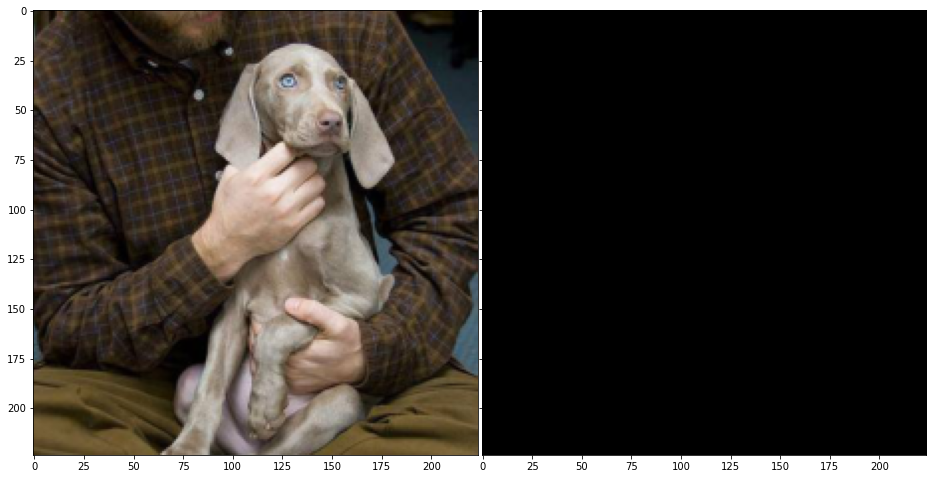

In [25]:
x , y = dloaders['valid'].dataset[0]
print (x.size())
print (y)

for i,(x,y) in enumerate(dloaders['train']):
  print (x.size())
  print (y.size())

  label = np.zeros((x.shape[0], 64))
  label[np.arange(x.shape[0]), y] = 1
  label = torch.tensor(label)

  print (label.size())

  x_ , mu , logvar  = cnnae(x.to(device),label.to(device))
  print (x_.size())
  fig = plt.figure(1, figsize=(16, 16))
  grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.05)
  imshow(grid[0],x[0].cpu())
  imshow (grid[1],x_[0].cpu().detach())
  break


  

In [26]:
from mpl_toolkits.axes_grid1 import AxesGrid

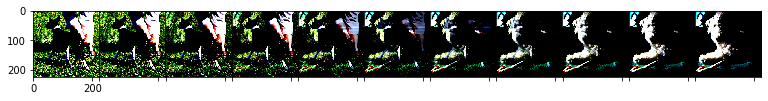

In [27]:
# pick two examples from the dataset
a = dloaders['valid'].dataset[i][0].view(3,224, 224)
b = dloaders['valid'].dataset[i+1][0].view(3,224, 224)

# build a grid
fig = plt.figure(figsize=(60,16))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1")

# interpolate between images
for k in range(11):
    z = k/10. * a + (1. - k/10.) * b
    im = grid[k].imshow(z.numpy().transpose((1, 2, 0)), interpolation="nearest")

In [28]:
# get low-dimentional representations
# print (a.size())
# print(a.view(-1, 28 * 28).size())
# x = torch.tensor(a.view(-1, 28 * 28).to(device))
# a_y = torch.tensor(dloaders['valid'].dataset[i][1]).view(1)
# a_emb = cnnae.encoder(x,a_y)   
# x = torch.tensor(b.view(-1, 28 * 28).to(device))
# b_emb = cnnae.encoder(x) 

# fig = plt.figure(figsize=(60,5))
# grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
#                 axes_pad=0.00, label_mode="1",)

# for k in range(11):
#     # interpolate in latent space
#     z_emb = k/10. * a_emb + (1. - k/10.) * b_emb
#     # use the latent code to decode the results
#     z = cnnae.decoder(z_emb)
#     im = grid[k].imshow(z.cpu().data.numpy().reshape(28,28), interpolation="nearest")

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step. 
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both. 

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

Write a comment on model comparison, things and ideas that helped boost the quality, and anything else you would like to share. 